In [89]:
import os
import tarfile
import pandas as pd
import matplotlib.pyplot as plt
import csv

In [90]:
#Reading and editing csvs
beerizer = pd.read_csv("src/data/matched_dataset_BA_RB_UT.csv")
matched_ratings = pd.read_csv("src/data/data_matched_beer_data/ratings.csv", header=[0, 1])
matched_ratings.columns = ['_'.join(col).strip() for col in matched_ratings.columns.values]
matched_ratings['ba_date'] = pd.to_datetime(matched_ratings['ba_date'], unit='s')
matched_ratings['rb_date'] = pd.to_datetime(matched_ratings['rb_date'], unit='s')

In [91]:
# Determining first review date
beer_first_review = matched_ratings.groupby('ba_beer_id').agg(
    first_review_date=('ba_date', 'min')
).reset_index()

# Add first review column
matched_ratings = matched_ratings.merge(beer_first_review, on='ba_beer_id', how='left')

# Calculate one year after the beers first review and filter review to be withing that year
matched_ratings['one_year_after_launch'] = matched_ratings['first_review_date'] + pd.DateOffset(years=1)
first_year_reviews = matched_ratings[
    (matched_ratings['ba_date'] >= matched_ratings['first_review_date']) &
    (matched_ratings['ba_date'] < matched_ratings['one_year_after_launch'])]

# Determine the total amount of reviews in the first year and overall
first_year_review_counts = first_year_reviews.groupby('ba_beer_id').size().reset_index(name='first_year_reviews')
total_review_counts = matched_ratings.groupby('ba_beer_id').size().reset_index(name='total_reviews')


In [92]:
# Merge all review counts
newcomer_beers = total_review_counts.merge(
    first_year_review_counts, on='ba_beer_id', how='left'
).fillna(0)

# Merge with beer names
newcomer_beers = newcomer_beers.merge(
    matched_ratings[['ba_beer_id', 'ba_beer_name']].drop_duplicates(),
    on='ba_beer_id',
    how='left')

# Calculate the ratio of first year reviews to total reviews
newcomer_beers['review_ratio'] = newcomer_beers['first_year_reviews'] / newcomer_beers['total_reviews']

# Filter out beers with ratio = 1 and sort by ratio in descending order
newcomer_beers = newcomer_beers[newcomer_beers['review_ratio'] != 1]
newcomer_beers = newcomer_beers.sort_values(by='review_ratio', ascending=False)

print("Top Beers by First Year Review Ratio:")
print(newcomer_beers[['ba_beer_name', 'first_year_reviews', 'total_reviews', 'review_ratio']])



Top Beers by First Year Review Ratio:
                                   ba_beer_name  first_year_reviews  \
3887                                     3Beans                  14   
5440                              Second Fiddle                  12   
4319                   Grassroots Arctic Saison                  10   
1322  Rogue Ten Thousand Brew Ale (Brew 10,000)                   9   
4243                                Troublesome                   8   
...                                         ...                 ...   
114                       Indica India Pale Ale                   1   
398                    Weihenstephaner Festbier                   1   
48                    Weihenstephaner Korbinian                   1   
926                               Blind Pig IPA                   1   
78                             Delirium Tremens                   1   

      total_reviews  review_ratio  
3887             15      0.933333  
5440             13      0.923077  
4

In [93]:
matched_ratings['year'] = matched_ratings['ba_date'].dt.year
reviews_per_beer_for_year = matched_ratings.groupby(['ba_beer_id', 'year']).size().reset_index(name='review_count')

# Calculate total reviews per beer to filter for at least 5 total reviews
total_reviews_per_beer = reviews_per_beer_for_year.groupby('ba_beer_id')['review_count'].sum().reset_index(name='total_reviews')
beers_with_enough_reviews = total_reviews_per_beer[total_reviews_per_beer['total_reviews'] >= 5]['ba_beer_id']

# # Calculation for mean reviews per year
# total_reviews_yearly = matched_ratings.groupby('year').size().reset_index(name='total_review_count')
# unique_beers_yearly = matched_ratings.groupby('year')['ba_beer_id'].nunique().reset_index(name='unique_beer_count')
# reviews_stats_per_year = total_reviews_yearly.merge(unique_beers_yearly, on='year')
# reviews_stats_per_year['mean_reviews_per_beer'] = reviews_stats_per_year['total_review_count'] / reviews_stats_per_year['unique_beer_count']

# # Calculation for median
# reviews_per_beer_per_year_all = matched_ratings.groupby(['year', 'ba_beer_id']).size().reset_index(name='review_count')
# median_reviews_per_year = reviews_per_beer_per_year_all.groupby('year')['review_count'].median().reset_index(name='median_reviews_per_beer')
# reviews_stats_per_year = reviews_stats_per_year.merge(median_reviews_per_year, on='year')

# Get the IDs and names of beers with enough reviews
filtered_newcomers = newcomer_beers[newcomer_beers['ba_beer_id'].isin(beers_with_enough_reviews)]
top_beer_ids = filtered_newcomers['ba_beer_id'].tolist()
top_beer_names = filtered_newcomers[['ba_beer_id', 'ba_beer_name']]

# Filter reviews for top beers
top_reviews = reviews_per_beer_for_year[reviews_per_beer_for_year['ba_beer_id'].isin(top_beer_ids)]
top_reviews = top_reviews.merge(top_beer_names, on='ba_beer_id', how='left').sort_values(by=['ba_beer_name', 'year'])

#Save the results
filtered_newcomers.to_csv("ReviewDensity_Newcomers_overall.csv", header=True, index=False, quotechar='"', quoting=csv.QUOTE_NONNUMERIC, na_rep='NaN')
top_reviews.to_csv("ReviewDensity_Newcomers_per_year.csv", header=True, index=False, quotechar='"', quoting=csv.QUOTE_NONNUMERIC, na_rep='NaN')


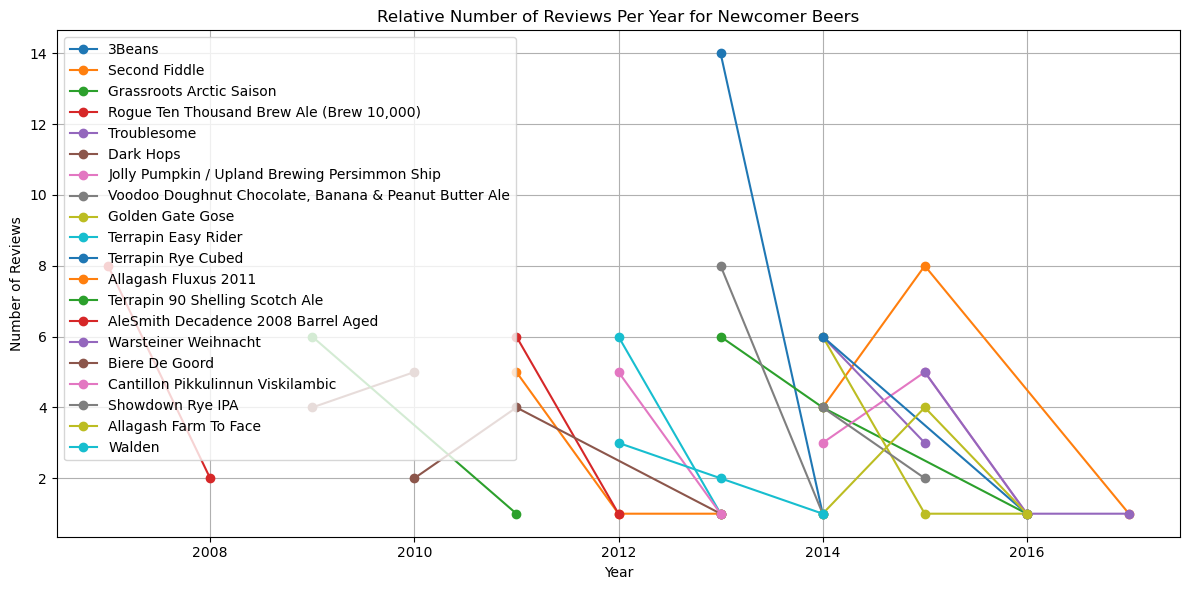

In [94]:
plt.figure(figsize=(12, 6))


legend_entries = []
for beer_id, beer_name in zip(newcomer_beers['ba_beer_id'].head(20), newcomer_beers['ba_beer_name'].head(20)):
    beer_data = top_reviews[top_reviews['ba_beer_id'] == beer_id].sort_values('year')
    if not beer_data.empty:  # Only plot and add to legend if there's data
        line, = plt.plot(beer_data['year'], beer_data['review_count'], marker='o', label=f"{beer_name}")
        legend_entries.append(line)


plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.title('Relative Number of Reviews Per Year for Newcomer Beers')
plt.legend(handles=legend_entries)
plt.grid(True)
plt.tight_layout()
plt.show()
